# Identifying the path of a tornado

This is a very simple example how the path of a tornando can be identified using IBM PAIRS leveraging its user-defined functions. On 10-20-2019 a major tornando went right through Dallas, TX (https://watchers.news/2019/10/25/ict-2019-dallas-tornadoes-the-costliest-tornado-event-in-texas-history-usa/)

In [58]:
from ibmpairs import paw, authentication
import matplotlib.pyplot as plt, pandas as pd, numpy as np, os
from datetime import datetime, timedelta
from scipy.signal import convolve2d
import logging

We set some auxiliary variables and configure the logging system. E.g. `iso8601` helps when converting datetime objects to strings in ISO 8601-compliant format.

In [2]:
oneSec = timedelta(seconds=1)
iso8601 = '%Y-%m-%dT%H:%M:%SZ'

logging.basicConfig(level=logging.WARNING)
pawLogger = logging.getLogger('ibmpairs.paw')
pawLogger.setLevel(logging.ERROR)

We use our API key to authenticate. To do so, we generate an authentication object `pairs_credentials`. When using the `paw` library, this can be used directly when instantiating a query via `paw.PAIRSQuery`. However, when submitting an API request directly (via e.g. python's `requests` module), we need to use a suitable HTTP header. We construct this directly as well. See `pairs_auth_headers`.

**Please replace `<YOUR-PAIRS-API-KEY>` with your PAIRS API key.**

In [71]:
pairs_api_key = '<YOUR-PAIRS-API-KEY>'

Specifically, we use `authentication.OAuth2` to retrieve the access token:

In [4]:
pairs_credentials = authentication.OAuth2(api_key=pairs_api_key)
pairs_auth_headers={
    'authorization' : f'Bearer {pairs_credentials.jwt_token}',
    'content-type' : 'application/json'
}

The token will expire after an hour. This notebook will run in less time, so this is no issue. For longer running jobs use `pairs_credentials.refresh_auth_token()` to refresh. See https://pairs.res.ibm.com/tutorial/tutorials/api/paw.html#refreshing-a-token for details.


## The PAIRS query

The relevant area is bounded by the following coordinates:

In [5]:
lat0 = '32.84'
lat1 = '32.96'
lon0 = '-96.90'
lon1 = '-96.70'

PAIRS data layers are identified by their IDs. Those can be found using the Data Explorer in the GUI as well as using the API.

Layer `49360` is the red band of the European Space Agency's Sentinel 2 satellite:

In [6]:
layer_id='49360'

Using the coordinates as well as the layer ID, we can define our query. `"snapshot"` identifies the most recent data searching from the timestamp backwards in 
time. That is, the following finds the most recent data one or before 2019-10-22 as well as 2019-10-07. These are labeled *before* and *after* respectively.

Subsequently, we calculate the difference between the two using
```
"expression": "$data_before-$data_after"
```
In principle we do not need the information stored in `data_before` and `data_after`. We save some resources by adding `"output" : False` to the relevant element in the `"layers"` array. This tells PAIRS that the data is used for calculation -- as is the case here -- but does not need to be returned.

In [51]:
query_json = {
    "layers": [
        {   
            "alias": "t_1",
            "id": layer_id,
            "output": False,
            "temporal" : {"intervals" : [
                {"snapshot" : "2019-10-22T00:00:00Z"}
            ]}
        },
        {
            "alias": "t_0",
            "id": layer_id,
            "output": False,
            "temporal" : {"intervals" : [
                {"snapshot" : "2019-10-07T00:00:00Z"}
            ]}
        },
        {
            "alias": "difference",
            "expression": "$t_0 - $t_1"
        }
    ],
    "name": "udf_change",
    "spatial" : {"type" : "square", "coordinates" : [lat0, lon0, lat1, lon1]},  
    "temporal": {"intervals": [{"start": "2019-10-22T00:00:00Z", "end": "2019-10-22T00:00:00Z", }]}
}

We submit our query ...

In [52]:
query = paw.PAIRSQuery(query_json, auth=pairs_credentials, authType='api-key')
query.submit()

... wait for it to complete, download the data and load it to memory.

In [53]:
query.poll_till_finished()
query.download()
query.create_layers()

Now that the query is completed and the data in memory, the `query` object holds metadata in `query.metadata` and the actual raster image(s) in `query.data`. The two dictionaries have the same keys.

We load the data (`im_diff`) as well as the spatial extent (`extent`).

In [56]:
query_metadata = pd.DataFrame(query.metadata).transpose()

id_string='Expression-difference[difference]-Exp'
extent = [
    query.metadata[id_string]['details']['boundingBox'][k]
    for k in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']
]
im_diff=query.data[id_string]

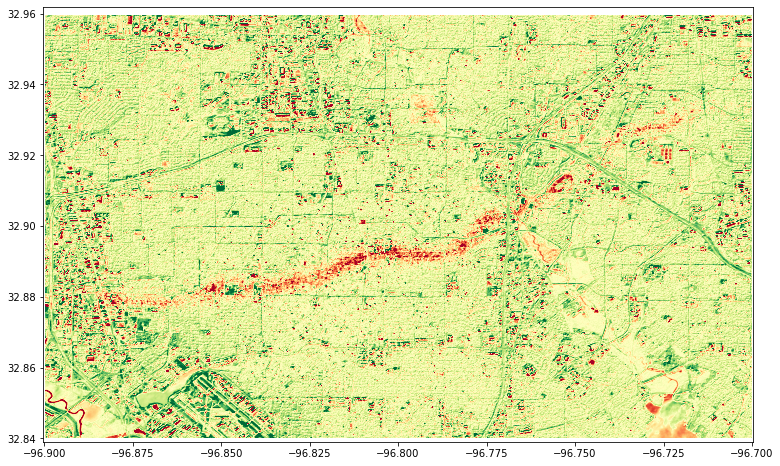

In [70]:
fig=plt.figure(figsize=(16,8))
plt.imshow(im_diff, extent = extent, cmap = 'RdYlGn', vmin=-0.05, vmax=0.05)
fig.savefig('Tornado-path.png')

Finally, we filter the image for better visualization.

In [59]:
n=10
kernel = np.ones((n,n),np.float32)/n/n
im_filtered = convolve2d(im_diff, kernel, mode='same', boundary='fill', fillvalue=np.nan)

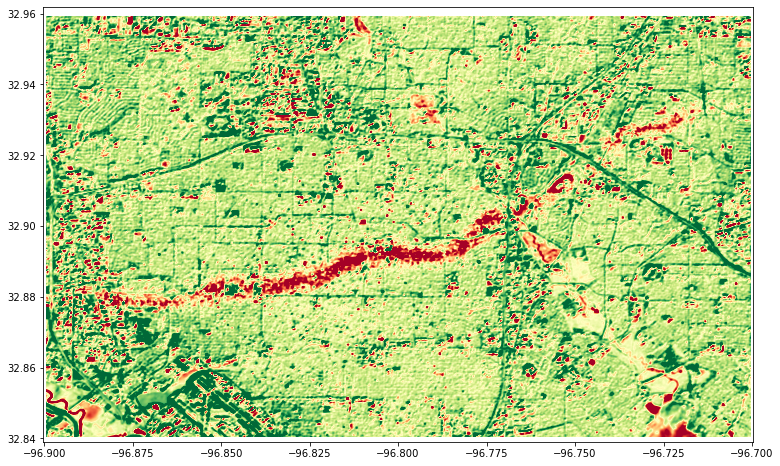

In [69]:
fig=plt.figure(figsize=(16,8))
plt.imshow(im_filtered, extent = extent, cmap = 'RdYlGn', vmin=-0.02, vmax=0.02)
fig.savefig('Tornado-path_filtered.png')